In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



import warnings
warnings.filterwarnings("ignore")

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive/')

import sys

#-------------------------------------------------------------------#
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#-------------------------------------------------------------------#

In [ ]:
def pca_factor_loadings(Z,load,labels=None):
    xs = Z[:,0]
    ys = Z[:,1]
    n = load.shape[0]

    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    #plt.scatter(xs * scalex,ys * scaley,c=y)
    plt.scatter(xs * scalex,ys * scaley,edgecolors='k')
    
    for i in range(n):
        plt.arrow(0, 0, load[i,0],load[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(load[i,0]* 1.15, load[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(load[i,0]* 1.15, load[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
#-------------------------------------------------------------------------------
def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)   

In [ ]:
# read  csv file
import io
uploaded = files.upload()
df=pd.read_csv(io.BytesIO(uploaded['Completions_DataSet.csv']),sep=";")

Saving Completions_DataSet.csv to Completions_DataSet (1).csv


In [ ]:
df.head()

,Stage Spacing,Cluster Spacing,Sand per ft (# per ft),Water per ft (gal per ft)
0,173,46,1117,10
1,167,39,1117,10
2,160,42,1037,10
3,156,40,1197,10
4,170,47,1117,10


In [ ]:
df.rename(columns={'Stage Spacing': 'stage',
                   'Cluster Spacing': 'cluster',
                   'Sand per ft (# per ft)':'sand',
                   'Water per ft (gal per ft)':'water'},
           inplace=True)


In [ ]:
df.head()

,stage,cluster,sand,water
0,173,46,1117,10
1,167,39,1117,10
2,160,42,1037,10
3,156,40,1197,10
4,170,47,1117,10


In [ ]:
# scaled dataset
X=df.values
scaler=StandardScaler()
scaler.fit(X)
X_std=scaler.transform(X)

# **PCA**

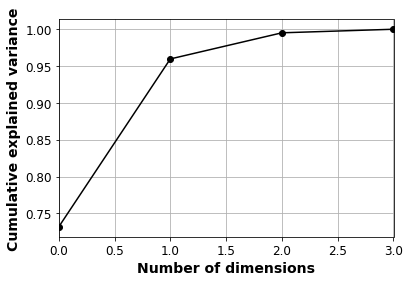

In [ ]:
# invoke PCA 
pca = PCA()
pca.fit(X_std)
pca.transform(X_std)

# explained variance
exp_var_pca=np.sum(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'ko-')
plt.xlim(0,3)
plt.xlabel('Number of dimensions')
plt.ylabel('Cumulative explained variance')
plt.grid()

In [ ]:
pca.explained_variance_ratio_

array([0.73152952, 0.22813831, 0.03548685, 0.00484531])

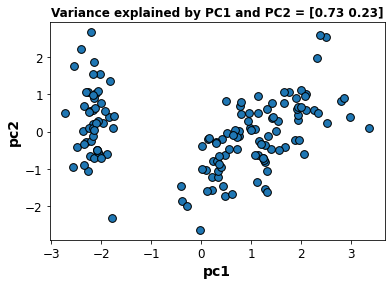

In [ ]:
# invoke pca with 2 dimensions
pca=PCA(n_components=2)
Z=pca.fit(X_std)
Z=pca.transform(X_std)

# plot figs
fig = plt.figure()
ax = fig.add_subplot(111)
sc=ax.scatter(Z[:,0], Z[:,1],s=60,edgecolors=(0,0,0))
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
plt.title(f"Variance explained by PC1 and PC2 = {np.round(pca.explained_variance_ratio_,2)}");
plt.savefig("pca.png",dpi=300)

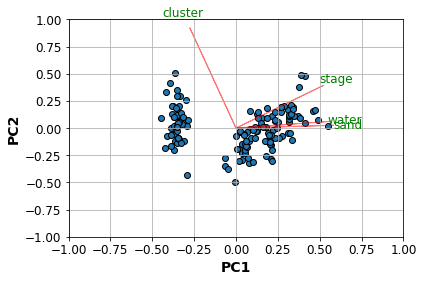

In [ ]:
# factor loadings
pca_factor_loadings(Z[:,0:2],np.transpose(pca.components_[0:2, :]),labels=['stage','cluster','sand','water'])

# **KPCA**

In [ ]:
# param_grid for KPCA best parameters
param_grid = [{
        "gamma": np.linspace(0.01, 0.5, 10),
        "kernel": ["rbf", "sigmoid", "linear", "poly"]
    }]

# invoke KPCA
kpca=KernelPCA(n_components=2,fit_inverse_transform=True, n_jobs=-1) 

# perform GridSearchCV to find best_params
grid_search = GridSearchCV(kpca, param_grid, cv=3, scoring=my_scorer)
grid_search.fit(X_std)

# extract best_params
kpca_gamma=grid_search.best_params_['gamma']
kpca_kernel=grid_search.best_params_['kernel']

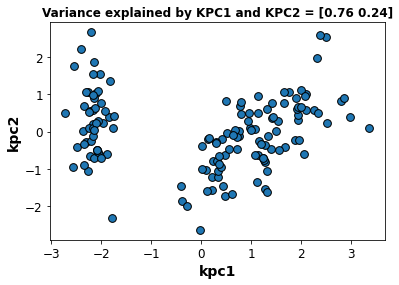

In [ ]:
# invoke KPCA with 2 components
# and best_params
kpca = KernelPCA(n_components = 2, kernel=kpca_kernel, gamma=kpca_gamma,fit_inverse_transform=True)

# obtain reduced dimension
Zk=kpca.fit(X_std)
Zk=kpca.transform(X_std)

# calculate explained variance
explained_variance = np.var(Zk, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# plot figures
fig = plt.figure()
ax = fig.add_subplot(111)
sc=ax.scatter(Zk[:,0], Zk[:,1],s=60,edgecolors=(0,0,0))
ax.set_xlabel('kpc1')
ax.set_ylabel('kpc2')
plt.title(f"Variance explained by KPC1 and KPC2 = {np.round(explained_variance_ratio,2)}");
plt.savefig("kpca.png",dpi=300)

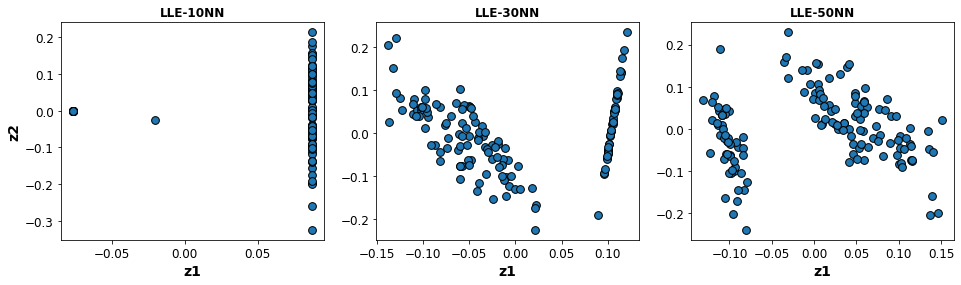

In [ ]:
# perform LLE with 10NN's
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
Zlle = lle.fit_transform(X_std)
# plot figures
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
sc=ax.scatter(Zlle[:,0], Zlle[:,1],s=60,edgecolors=(0,0,0))
ax.set_xlabel('z1')
ax.set_ylabel('z2')
plt.title(f"LLE-10NN");

# perform LLE with 30NN's
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=30, random_state=42)
Zlle = lle.fit_transform(X_std)
# plot figures
ax = fig.add_subplot(132)
sc=ax.scatter(Zlle[:,0], Zlle[:,1],s=60,edgecolors=(0,0,0))
ax.set_xlabel('z1')
plt.title(f"LLE-30NN");

# perform LLE with 50NN's
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=50, random_state=42)
Zlle = lle.fit_transform(X_std)
# plot figures
ax = fig.add_subplot(133)
sc=ax.scatter(Zlle[:,0], Zlle[:,1],s=60,edgecolors=(0,0,0))
ax.set_xlabel('z1')
plt.title(f"LLE-50NN");
plt.savefig("lle.png",dpi=300)

In [ ]:
mds = MDS(n_components=2, random_state=42)
isomap = Isomap(n_components=2)
tsne = TSNE(n_components=2, random_state=42)

Zmds = mds.fit_transform(X_std)
Ziso=isomap.fit_transform(X_std)
Ztsne=tsne.fit_transform(X_std)

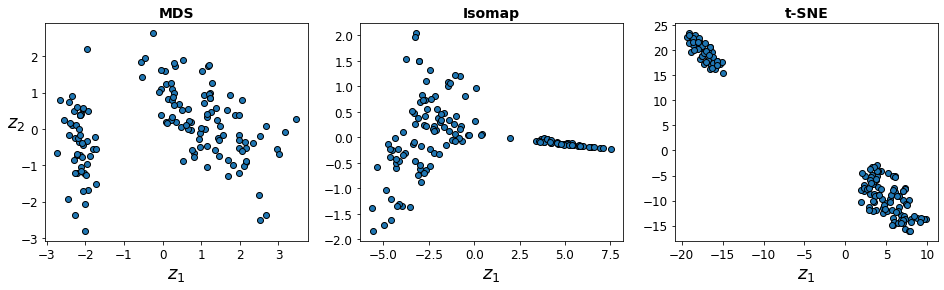

In [ ]:
titles = ["MDS", "Isomap", "t-SNE"]
subplots=(131,132,133)
plt.figure(figsize=(16,4))
for subplot,title,Z_red in zip(subplots,titles,(Zmds,Ziso,Ztsne)):
  plt.subplot(subplot)
  plt.title(title, fontsize=14)
  sc=plt.scatter(Z_red[:, 0], Z_red[:, 1],edgecolors=(0,0,0))
  plt.xlabel("$z_1$", fontsize=18)
  if subplot == 131:
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.savefig("manifold_dim_red.png",dpi=300)

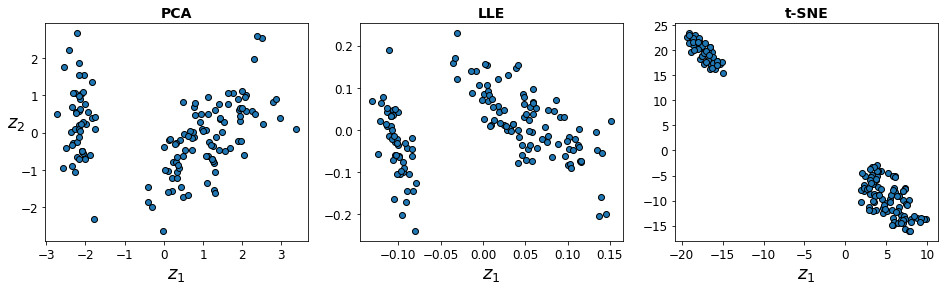

In [ ]:
titles = ["PCA", "LLE", "t-SNE"]
subplots=(131,132,133)
plt.figure(figsize=(16,4))
for subplot,title,Z_red in zip(subplots,titles,(Z,Zlle,Ztsne)):
  plt.subplot(subplot)
  plt.title(title, fontsize=14)
  sc=plt.scatter(Z_red[:, 0], Z_red[:, 1],edgecolors=(0,0,0))
  plt.xlabel("$z_1$", fontsize=18)
  if subplot == 131:
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.savefig("comp_dim_red_pca_lle_tsne.png",dpi=300)